In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import matplotlib
#matplotlib.use('nbagg')
import matplotlib.pyplot as plt
#%matplotlib widget

In [4]:
import dask.dataframe as dd
import folium
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint as sp_randint
from time import time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.cluster import MiniBatchKMeans
import gpxpy.geo
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
np.random.seed(7)

In [5]:
import time
import datetime
import warnings
import math
warnings.filterwarnings("ignore")

In [6]:
df=dd.read_csv('yellow_tripdata_2015-01.csv')
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

In [7]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [8]:
#bounding area for new york : -(lat,long) (40.5774, -74.15) & (40.9176,-73.7004)
#Pickup locations

outlier_location=df[((df.pickup_latitude<=40.5774)| (df.pickup_longitude<=-74.15) | (df.pickup_latitude>=40.9176)| (df.pickup_longitude>= -73.7004))]

#Map
map_outl = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

sample_locations = outlier_location.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_outl)
map_outl

In [9]:
#bounding area for new york : -(lat,long) (40.5774, -74.15) & (40.9176,-73.7004)
#Pickup locations

outlier_location=df[((df.dropoff_latitude<=40.5774)| (df.dropoff_longitude<=-74.15) | (df.dropoff_latitude>=40.9176)| (df.dropoff_longitude>= -73.7004))]

#Map
map_outl = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

sample_locations = outlier_location.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['dropoff_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_outl)
map_outl

In [10]:
def convert_unix(s):
    x=datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple()
    return time.mktime(x)

def trip_times(data):
    d=data[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    
    pickup_d=[convert_unix(x) for x in d['tpep_pickup_datetime'].values]
    dropoff_d=[convert_unix(x) for x in d['tpep_dropoff_datetime'].values]
    durations=(np.array(dropoff_d)-np.array(pickup_d))/float(60)
    
    frame=data[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    frame['pickup_d']=pickup_d
    frame['dropoff_d']=dropoff_d
    frame['trip_duration']=durations
    frame['speed']=60*(frame['trip_distance']/frame['trip_duration'])
    return frame

In [11]:
new=trip_times(df)

In [12]:
new.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,pickup_d,dropoff_d,trip_duration,speed
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,1.421329e+09,1.421330e+09,18.050000,5.285319
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,1.420902e+09,1.420903e+09,19.833333,9.983193
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,1.420902e+09,1.420903e+09,10.050000,10.746269
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.420902e+09,1.420902e+09,1.866667,16.071429
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,1.420902e+09,1.420903e+09,19.316667,9.318378


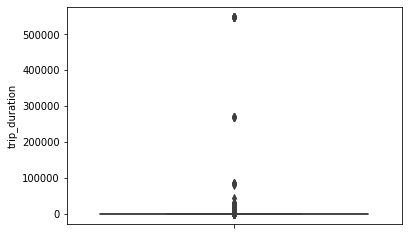

In [13]:
sns.boxplot(y='trip_duration',data=new)
plt.show()

In [14]:
for i in range(0,100,10):
    var = new["trip_duration"].values
    var = np.sort(var,axis=None)
    print('{}th Percentile is {}'.format(i,var[int(len(var)*(float(i)/100))]))
print('100th percentile:',var[-1]) 

0th Percentile is -1211.0166666666667
10th Percentile is 3.8333333333333335
20th Percentile is 5.383333333333334
30th Percentile is 6.816666666666666
40th Percentile is 8.3
50th Percentile is 9.95
60th Percentile is 11.866666666666667
70th Percentile is 14.283333333333333
80th Percentile is 17.633333333333333
90th Percentile is 23.45
100th percentile: 548555.6333333333


In [15]:
for i in range(90,100):
    var = new["trip_duration"].values
    var = np.sort(var,axis=None)
    print('{}th Percentile is {}'.format(i,var[int(len(var)*(float(i)/100))]))
print('100th percentile:',var[-1])

90th Percentile is 23.45
91th Percentile is 24.35
92th Percentile is 25.383333333333333
93th Percentile is 26.55
94th Percentile is 27.933333333333334
95th Percentile is 29.583333333333332
96th Percentile is 31.683333333333334
97th Percentile is 34.46666666666667
98th Percentile is 38.71666666666667
99th Percentile is 46.75
100th percentile: 548555.6333333333


In [16]:
for i in np.arange(0.0, 1.0, 0.1):
    var =new["trip_duration"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 46.75
99.1 percentile value is 48.06666666666667
99.2 percentile value is 49.56666666666667
99.3 percentile value is 51.28333333333333
99.4 percentile value is 53.31666666666667
99.5 percentile value is 55.833333333333336
99.6 percentile value is 59.13333333333333
99.7 percentile value is 63.9
99.8 percentile value is 71.86666666666666
99.9 percentile value is 101.6
100 percentile value is  548555.6333333333


In [17]:
#Removing more then 720mins trip durations

newmod=new[(new.trip_duration>1)&(new.trip_duration<720)]

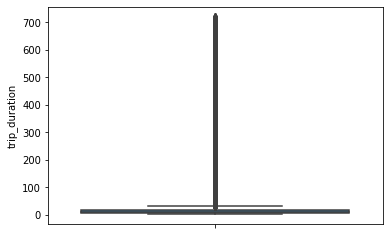

In [18]:
sns.boxplot(y='trip_duration',data=newmod)
plt.show()

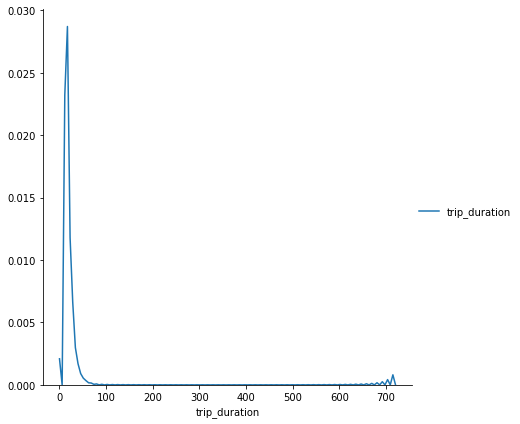

In [19]:
sns.FacetGrid(newmod,size=6) \
      .map(sns.kdeplot,"trip_duration") \
      .add_legend();
plt.show();

In [20]:
newmod['speed']=60*(newmod['trip_distance']/newmod['trip_duration'])

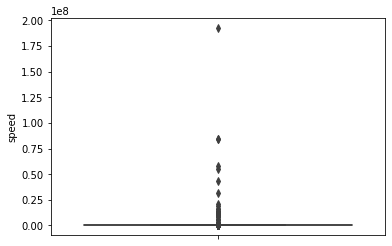

In [21]:
sns.boxplot(y='speed',data=newmod)
plt.show()

In [22]:
#Printing out Percentiles for detecting outliers\

for i in range(0,100,10):
    var=newmod['speed'].values
    var=np.sort(var,axis=None)
    print('{}th percentile is {}'.format(i,var[int(len(var)*(float(i)/100))]))

0th percentile is 0.0
10th percentile is 6.409495548961425
20th percentile is 7.80952380952381
30th percentile is 8.929133858267717
40th percentile is 9.98019801980198
50th percentile is 11.06865671641791
60th percentile is 12.286689419795222
70th percentile is 13.796407185628745
80th percentile is 15.963224893917962
90th percentile is 20.186915887850468


In [23]:
for i in range(90,100):
    var=newmod['speed'].values
    var=np.sort(var,axis=None)
    print('{}th percentile is {}'.format(i,var[int(len(var)*(float(i)/100))]))

90th percentile is 20.186915887850468
91th percentile is 20.91645569620253
92th percentile is 21.752988047808763
93th percentile is 22.721893491124263
94th percentile is 23.844155844155843
95th percentile is 25.182552504038775
96th percentile is 26.80851063829787
97th percentile is 28.84304932735426
98th percentile is 31.591128254580514
99th percentile is 35.7513566847558


In [24]:
for i in np.arange(0.0, 1.0, 0.1):
    var =newmod["speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.7513566847558
99.1 percentile value is 36.31084727468969
99.2 percentile value is 36.91470054446461
99.3 percentile value is 37.588235294117645
99.4 percentile value is 38.33035714285714
99.5 percentile value is 39.17580340264651
99.6 percentile value is 40.15384615384615
99.7 percentile value is 41.338301043219076
99.8 percentile value is 42.86631016042781
99.9 percentile value is 45.3107822410148
100 percentile value is  192857142.85714284


In [25]:
newmod_speed=newmod[(newmod['speed']>1)&(newmod['speed']<45)]

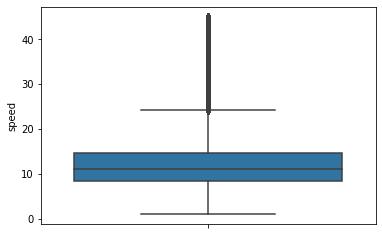

In [26]:
sns.boxplot(y='speed',data=newmod_speed)
plt.show()

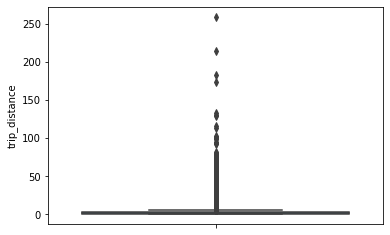

In [27]:
sns.boxplot(y='trip_distance',data=newmod_speed)
plt.show()

In [28]:
for i in range(0,100,10):
    var=newmod_speed['trip_distance'].values
    var=np.sort(var,axis=None)
    print('{}th percentile is {}'.format(i,var[int(len(var)*float(i)/100)]))

0th percentile is 0.02
10th percentile is 0.67
20th percentile is 0.9
30th percentile is 1.1
40th percentile is 1.4
50th percentile is 1.7
60th percentile is 2.08
70th percentile is 2.61
80th percentile is 3.6
90th percentile is 5.98


In [29]:
for i in range(90,100):
    var=newmod_speed['trip_distance'].values
    var=np.sort(var,axis=None)
    print('{}th percentile is {}'.format(i,var[int(len(var)*float(i)/100)]))
print('100th percentile is',var[-1])

90th percentile is 5.98
91th percentile is 6.46
92th percentile is 7.09
93th percentile is 7.86
94th percentile is 8.73
95th percentile is 9.6
96th percentile is 10.6
97th percentile is 12.1
98th percentile is 16.02
99th percentile is 18.17
100th percentile is 258.9


In [30]:
for i in np.arange(0.0, 1.0, 0.1):
    var =newmod_speed["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])
    

99.0 percentile value is 18.17
99.1 percentile value is 18.36
99.2 percentile value is 18.6
99.3 percentile value is 18.82
99.4 percentile value is 19.12
99.5 percentile value is 19.5
99.6 percentile value is 19.95
99.7 percentile value is 20.5
99.8 percentile value is 21.21
99.9 percentile value is 22.55
100 percentile value is  258.9


In [31]:
newmod_dist=newmod_speed[(newmod_speed.trip_distance>0)&(newmod_speed.trip_distance<23)]

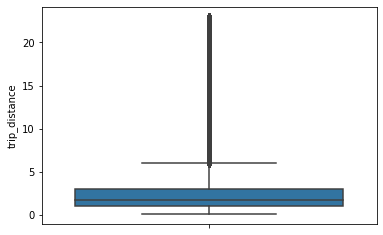

In [32]:
sns.boxplot(y='trip_distance',data=newmod_dist)
plt.show()

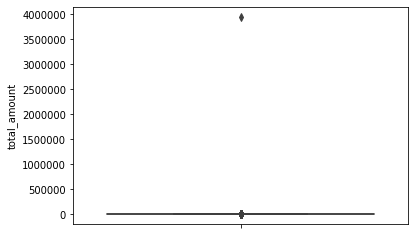

In [33]:
sns.boxplot(y='total_amount',data=newmod_dist)
plt.show()

In [34]:
for i in range(0,100,10):
    var=newmod_dist['total_amount'].values
    var=np.sort(var,axis=None)
    print('{}th percentile is {}'.format(i,var[int(len(var)*float(i)/100)]))

0th percentile is -242.55
10th percentile is 6.35
20th percentile is 7.8
30th percentile is 8.8
40th percentile is 9.8
50th percentile is 11.16
60th percentile is 12.8
70th percentile is 14.8
80th percentile is 18.3
90th percentile is 25.8


In [35]:
for i in range(90,100):
    var=newmod_dist['total_amount'].values
    var=np.sort(var,axis=None)
    print('{}th percentile is {}'.format(i,var[int(len(var)*float(i)/100)]))

90th percentile is 25.8
91th percentile is 27.25
92th percentile is 29.12
93th percentile is 31.42
94th percentile is 34.63
95th percentile is 38.13
96th percentile is 42.13
97th percentile is 47.46
98th percentile is 57.6
99th percentile is 65.8


In [36]:
for i in np.arange(0.0,1.0,0.1):
    var=newmod_dist['total_amount'].values
    var=np.sort(var,axis=None)
    print('{}th percentile is {}'.format(99+i,var[int(len(var)*(float(99+i)/100))]))
print('100th percentile is ',var[-1])

99.0th percentile is 65.8
99.1th percentile is 67.4
99.2th percentile is 68.71
99.3th percentile is 69.6
99.4th percentile is 69.73
99.5th percentile is 69.73
99.6th percentile is 69.76
99.7th percentile is 72.46
99.8th percentile is 75.06
99.9th percentile is 86.55
100th percentile is  3950611.6


In [37]:
for i in np.arange(0.0,0.1,0.01):
    var=newmod_dist['total_amount'].values
    var=np.sort(var,axis=None)
    print('{}th percentile is {}'.format(99.9+i,var[int(len(var)*(float(99.9+i)/100))]))
print('100th percentile is ',var[-1])

99.9th percentile is 86.55
99.91000000000001th percentile is 88.56
99.92th percentile is 90.6
99.93th percentile is 92.9
99.94000000000001th percentile is 95.3
99.95th percentile is 97.85
99.96000000000001th percentile is 100.3
99.97th percentile is 104.3
99.98th percentile is 109.8
99.99000000000001th percentile is 120.56
100th percentile is  3950611.6


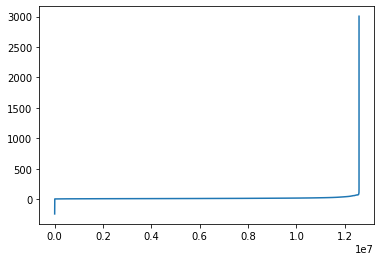

In [38]:
plt.plot(var[:-2])
plt.show()

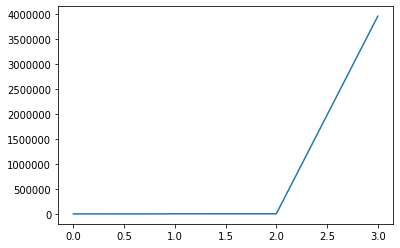

In [39]:
plt.plot(var[-4:])
plt.show()

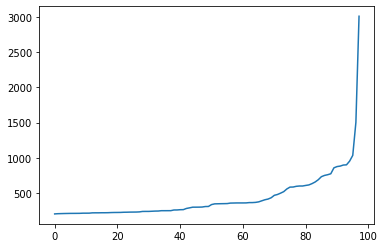

In [40]:
plt.plot(var[-100:-2])
plt.show()

In [41]:
def remove_outliers(new_frame):
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_duration > 0) & (new_frame.trip_duration < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.speed < 45.31) & (new_frame.speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    

    return new_frame        

In [42]:
new_outlierfree = remove_outliers(new)
print("fraction of data points that remain after removing outliers", float(len(new_outlierfree))/len(new))

fraction of data points that remain after removing outliers 0.9703576425607495


In [43]:
new_outlierfree.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,pickup_d,dropoff_d,trip_duration,speed
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,1.421329e+09,1.421330e+09,18.050000,5.285319
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,1.420902e+09,1.420903e+09,19.833333,9.983193
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,1.420902e+09,1.420903e+09,10.050000,10.746269
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.420902e+09,1.420902e+09,1.866667,16.071429
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,1.420902e+09,1.420903e+09,19.316667,9.318378


In [44]:
def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    new_outlierfree['pickup_cluster'] = kmeans.predict(new_outlierfree[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

coords=new_outlierfree[['pickup_latitude','pickup_longitude']].values
neighbours=[]

def find_distance(centers,cluster_len):
    right_points=0
    wrong_points=0
    right=[]
    wrong=[]
    min_dist=1000
    for i in range(0,cluster_len):
        right_points=0
        wrong_points=0
        
        for j in range(0,cluster_len):
            if(i!=j):
                distance=gpxpy.geo.haversine_distance(centers[i][0],centers[i][1],centers[j][0],centers[j][1])
                min_dist=min(min_dist,distance/(1.60934*1000))
                if(distance/(1.60934*1000)<=2.0):
                    right_points+=1
                else:
                    wrong_points+=1
        right.append(right_points)
        wrong.append(wrong_points)
        
    neighbours.append(right)
    print('k=',cluster_len,'Right points:',np.ceil(sum(right)/len(right)),'\t\t Wrong pts:',np.ceil(sum(wrong)/len(wrong)),'\t Min dist:',min_dist)


In [45]:
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_distance(cluster_centers, cluster_len)

k= 10 Right points: 2.0 		 Wrong pts: 8.0 	 Min dist: 1.0945442325142543
k= 20 Right points: 4.0 		 Wrong pts: 16.0 	 Min dist: 0.7131298007387813
k= 30 Right points: 8.0 		 Wrong pts: 22.0 	 Min dist: 0.5185088176172206
k= 40 Right points: 8.0 		 Wrong pts: 32.0 	 Min dist: 0.5069768450363973
k= 50 Right points: 12.0 		 Wrong pts: 38.0 	 Min dist: 0.365363025983595
k= 60 Right points: 14.0 		 Wrong pts: 46.0 	 Min dist: 0.34704283494187155
k= 70 Right points: 16.0 		 Wrong pts: 54.0 	 Min dist: 0.30502203163244707
k= 80 Right points: 18.0 		 Wrong pts: 62.0 	 Min dist: 0.29220324531738534
k= 90 Right points: 21.0 		 Wrong pts: 69.0 	 Min dist: 0.18257992857034985


In [46]:
#best is k=40 min dist-> 0.50
kmeans=MiniBatchKMeans(n_clusters=40,random_state=42,batch_size=10000).fit(coords)
new_outlierfree['pickup_cluster']=kmeans.predict(new_outlierfree[['pickup_latitude','pickup_longitude']].values)

    

In [47]:
#Plotting Cluster Centres
cc = kmeans.cluster_centers_
cluster_len = len(cc)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cc[i][0],cc[i][1])), popup=(str(cc[i][0])+str(cc[i][1]))).add_to(map_osm)


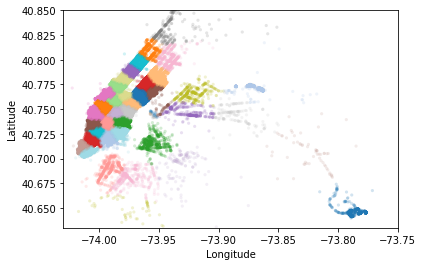

In [48]:
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(new_outlierfree)

In [49]:
def pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_d'].values]
    #One for each month
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    start_pickup_unix=unix_times[year-2015][month-1]
    #gmt to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame
    

In [50]:
#Clustering and binning for 2015-1

kmeans=MiniBatchKMeans(n_clusters=40,random_state=42,batch_size=10000).fit(coords)
new_outlierfree['pickup_cluster']=kmeans.predict(new_outlierfree[['pickup_latitude','pickup_longitude']].values)
jan2015=pickup_bins(new_outlierfree,1,2015)
jan2015_grouped=jan2015[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()



In [51]:
def dataprep(month,kmeans,month_no,year_no):
    frame_with_durations = trip_times(month)
    frame_without_outliers=remove_outliers(frame_with_durations)
    frame_without_outliers['pickup_cluster'] = kmeans.predict(frame_without_outliers[['pickup_latitude', 'pickup_longitude']])
    final=pickup_bins(frame_without_outliers,month_no,year_no)
    final_grouped=final[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final,final_grouped
    

In [52]:
%%time
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

jan_2016_frame,jan_2016_groupby = dataprep(month_jan_2016,kmeans,1,2016)
feb_2016_frame,feb_2016_groupby = dataprep(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = dataprep(month_mar_2016,kmeans,3,2016)

Wall time: 18min 48s


In [53]:
#jan_2016_frame.to_csv('jan_2016_frame_processes.csv')
#feb_2016_frame.to_csv('feb_2016_frame_processes.csv')
#mar_2016_frame.to_csv('mar_2016_frame_processes.csv')
#jan2015.to_csv('jan_2015_frame_processes.csv')


In [54]:
def unique_bins(frame,verb=None):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        
        list_unq = list(set(new['pickup_bins']))
        if(verb==1):
            print(i+1,'th cluster pickup bins:',len(list(new['pickup_bins'])))
            print(i+1,'th cluster unique pickup bins:',len(list_unq))
            print('--'*60)
        list_unq.sort()
        values.append(list_unq)
    return values

In [55]:
%%time

#jan
jan_2015_unique = unique_bins(jan2015)
jan_2016_unique = unique_bins(jan_2016_frame)

#feb
feb_2016_unique = unique_bins(feb_2016_frame)

#march
mar_2016_unique = unique_bins(mar_2016_frame)

Wall time: 16.8 s


In [56]:
for i in range(40):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2015_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  27
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  151
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  34
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  427
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  43
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  51
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  23
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  32
-----------

In [57]:
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions      
                

In [58]:
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [59]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2015_fill = fill_missing(jan2015_grouped['trip_distance'].values,jan_2015_unique)

#Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan2015_grouped['trip_distance'].values,jan_2015_unique)

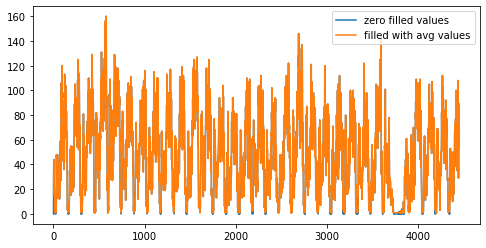

In [60]:
plt.figure(figsize=(8,4))
plt.plot(jan_2015_fill[4464:8920], label="zero filled values")
plt.plot(jan_2015_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

In [61]:
jan_2015_smooth = smoothing(jan2015_grouped['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)

In [62]:
regions_cum = []
for i in range(0,40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])
    
#4464+4176+4464 = total bins

In [63]:
print('Total Lists',len(regions_cum),'\t Each list have :',len(regions_cum[0]),' bins')


Total Lists 40 	 Each list have : 13104  bins


Cluster:   1


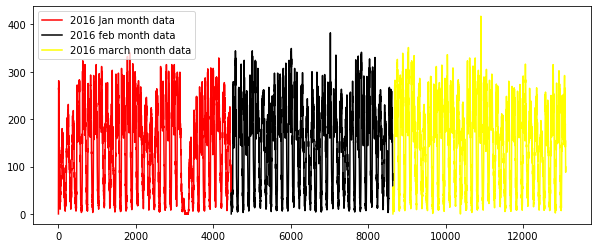

Cluster:   2


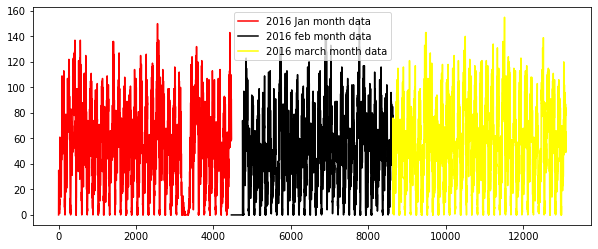

Cluster:   3


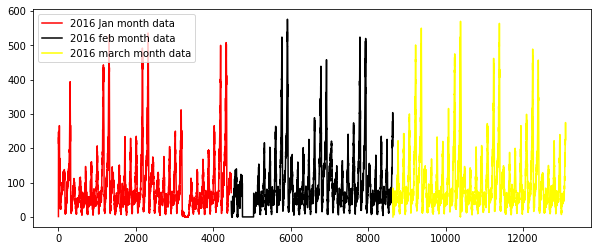

Cluster:   4


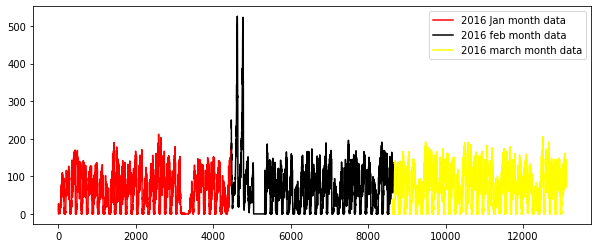

Cluster:   5


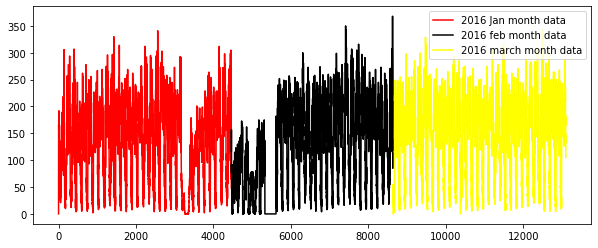

Cluster:   6


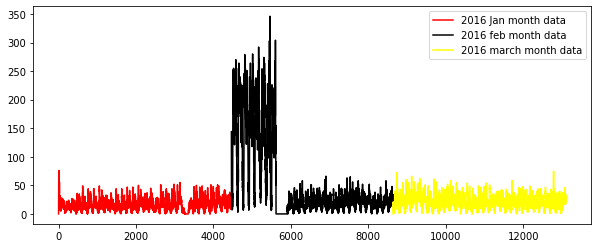

Cluster:   7


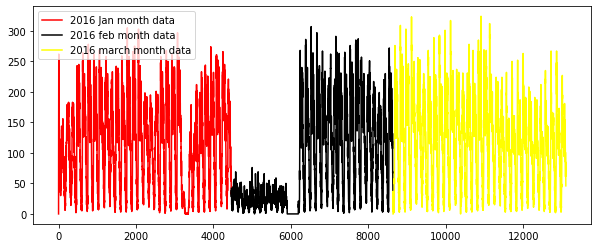

Cluster:   8


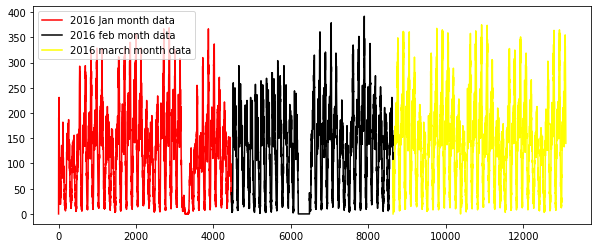

Cluster:   9


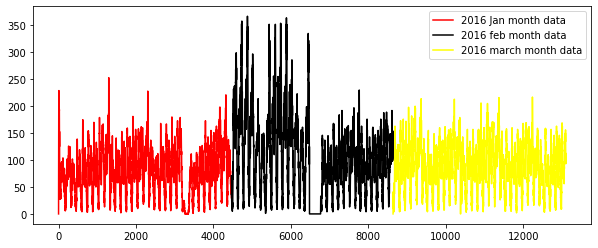

Cluster:   10


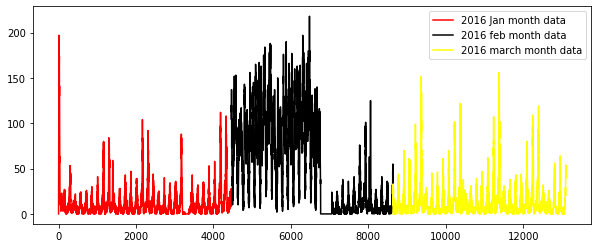

Cluster:   11


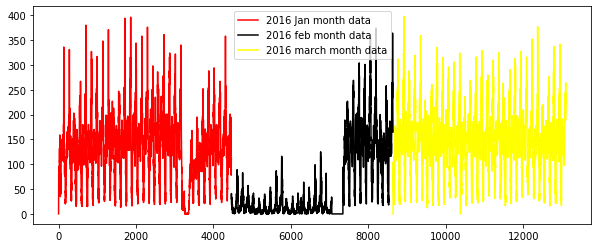

Cluster:   12


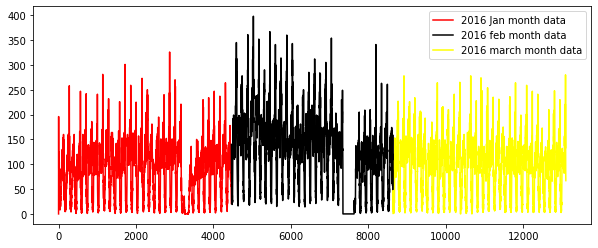

Cluster:   13


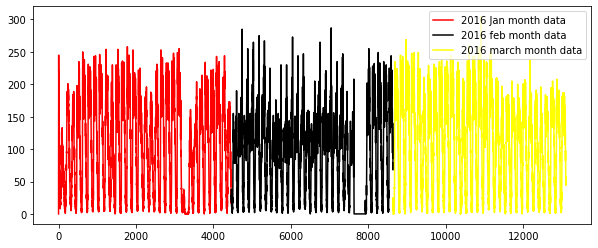

Cluster:   14


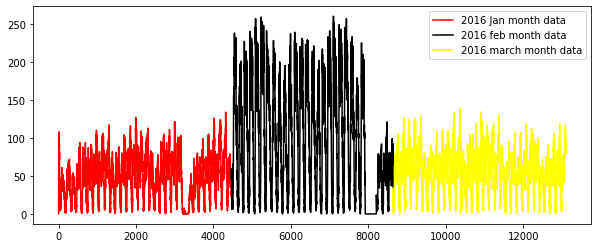

Cluster:   15


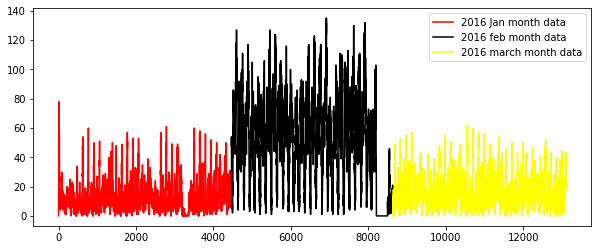

Cluster:   16


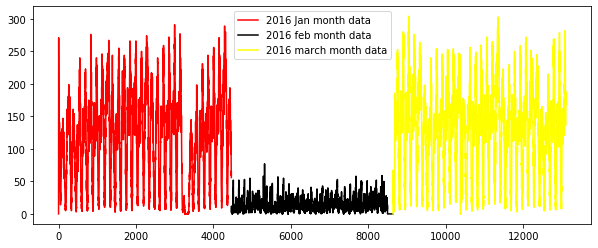

Cluster:   17


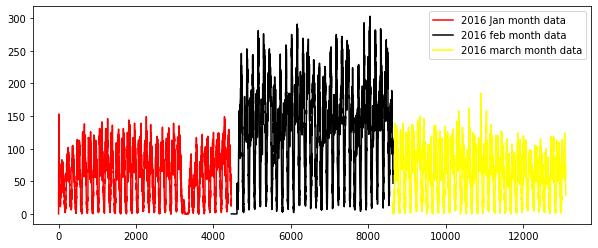

Cluster:   18


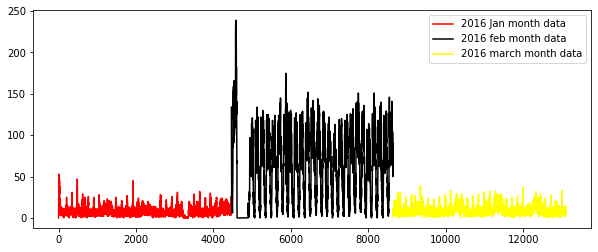

Cluster:   19


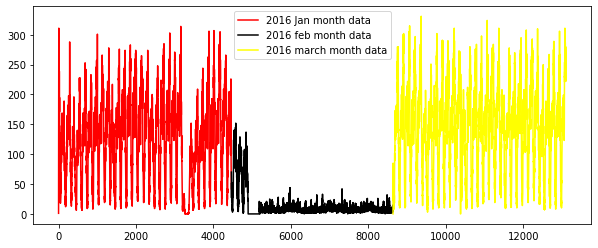

Cluster:   20


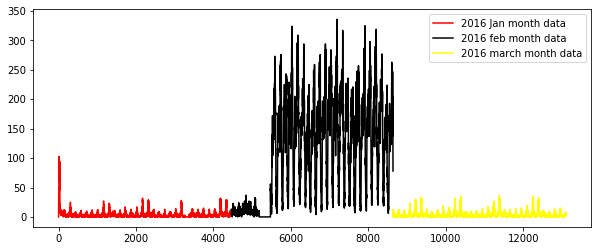

Cluster:   21


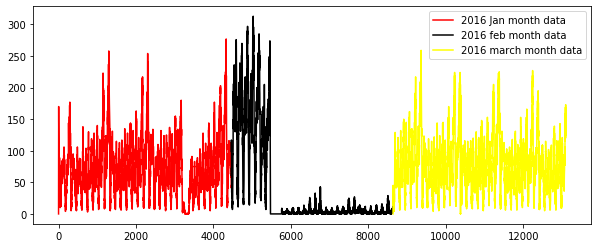

Cluster:   22


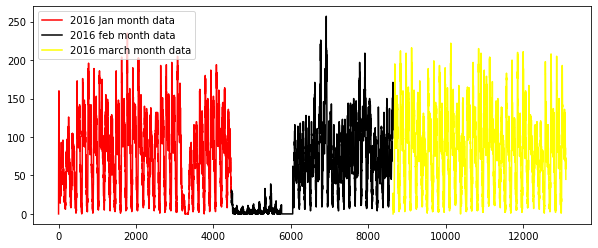

Cluster:   23


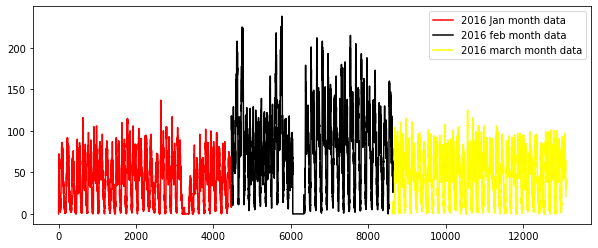

Cluster:   24


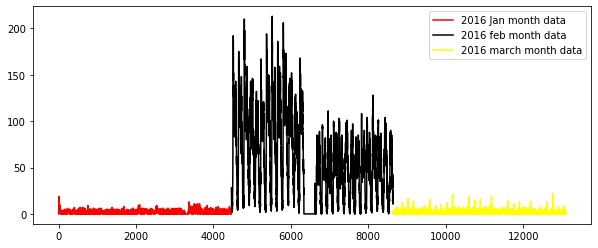

Cluster:   25


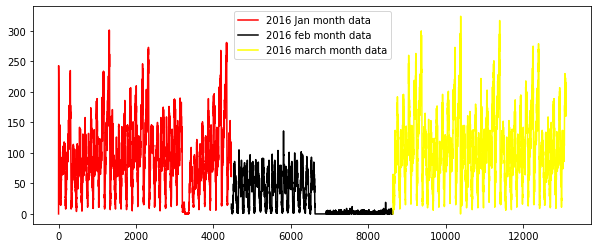

Cluster:   26


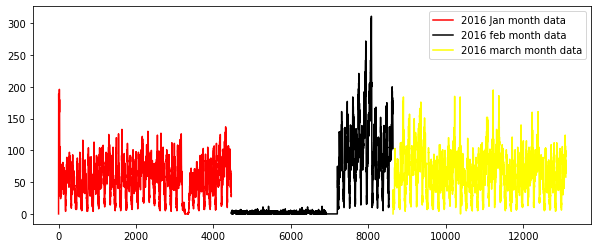

Cluster:   27


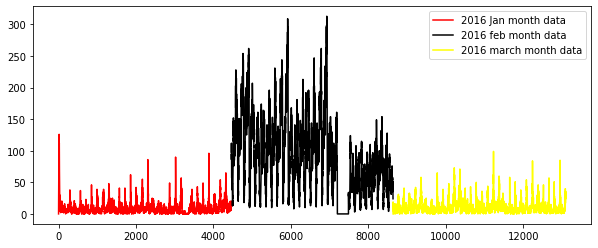

Cluster:   28


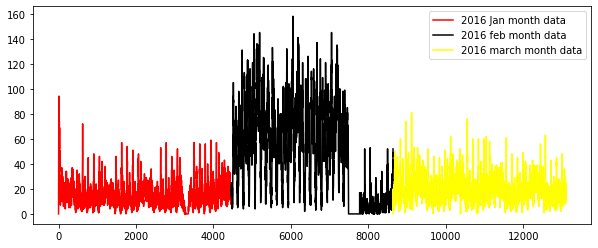

Cluster:   29


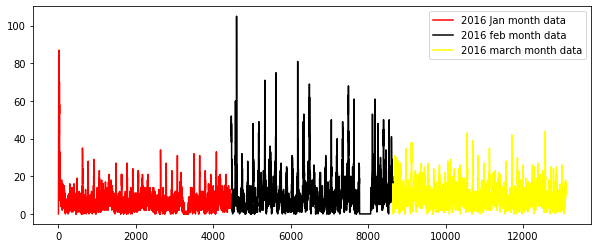

Cluster:   30


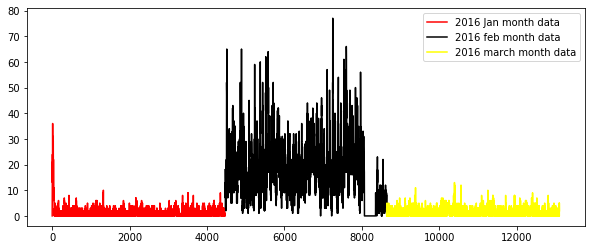

Cluster:   31


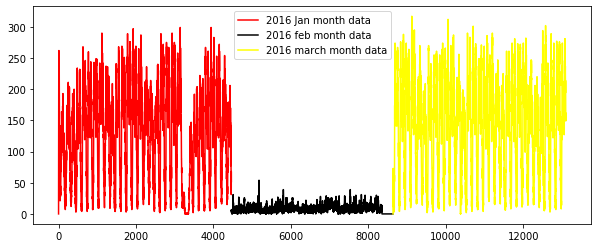

Cluster:   32


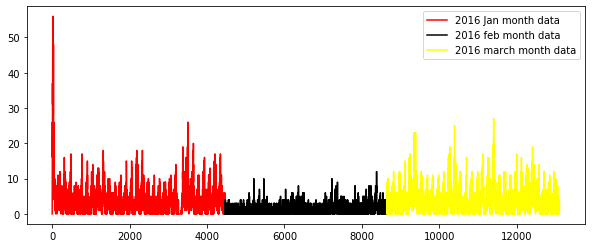

Cluster:   33


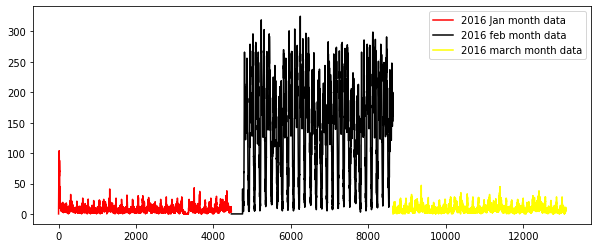

Cluster:   34


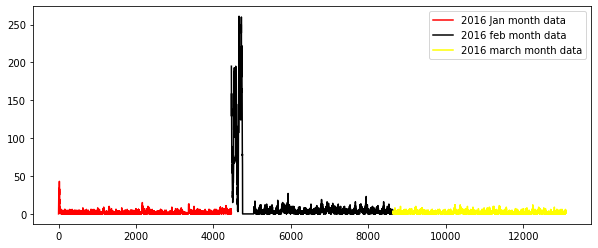

Cluster:   35


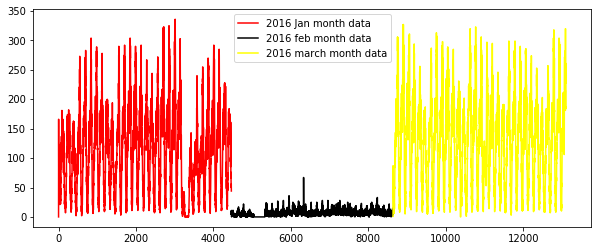

Cluster:   36


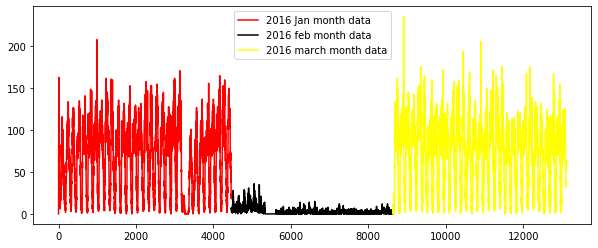

Cluster:   37


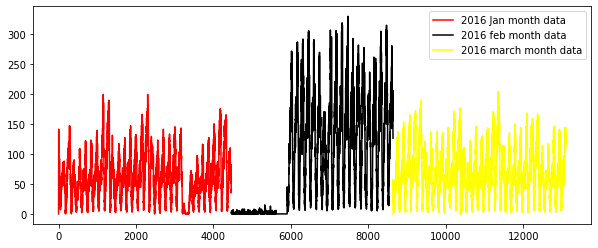

Cluster:   38


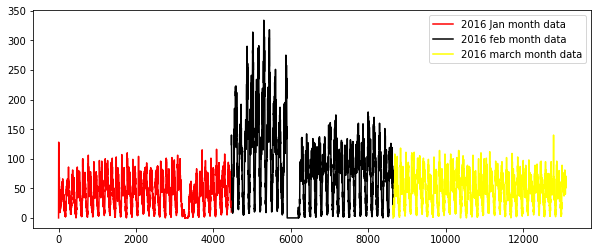

Cluster:   39


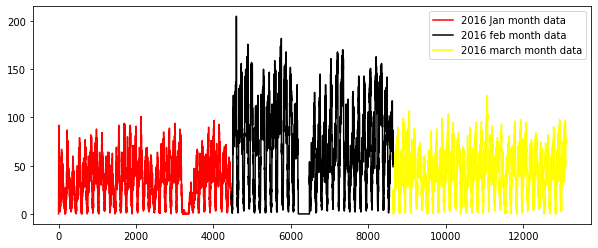

Cluster:   40


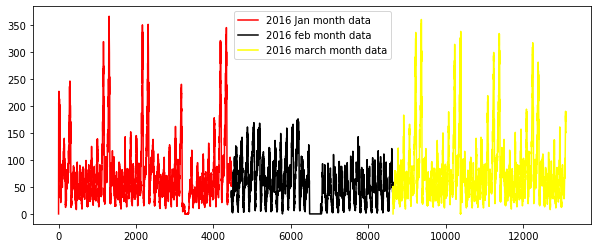

In [64]:
first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))
for i in range(40):
    print('Cluster:  ',i+1)
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i][:4464], color='red', label='2016 Jan month data')
    plt.plot(second_x,regions_cum[i][4464:8640], color='black', label='2016 feb month data')
    plt.plot(third_x,regions_cum[i][8640:], color='yellow', label='2016 march month data')
    plt.legend()
    plt.show()

In [65]:
Y = np.fft.fft(np.array(jan_2016_smooth)[0:4460])
freq = np.fft.fftfreq(4460, 1)
plt.figure()
plt.plot( freq, np.abs(Y))
plt.xlabel("Frequency")
plt.ylabel("Amplitude")


In [66]:
#Features for baseline models
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2015_smooth
ratios_jan['Prediction']=jan_2016_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [67]:
#rt=pt2016/pt2015
#pt2016 = rt * pt2015
#rt=rt-1*rt-2....rt-n/n
def ma_ratios(ratios,month):
    pratio=(ratios['Ratios'].values)[0]
    error=[]
    pvalues=[]
    window_size=3
    prvalues=[]
    for i in range(0,4464*40):
        if i%4464==0:
            #rsetting vals for each cluster
            prvalues.append(0)
            pvalues.append(0)
            error.append(0)
            continue
        prvalues.append(pratio)
        pvalues.append(int(((ratios['Given'].values)[i])*pratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*pratio)-(ratios['Prediction'].values)[i],1))))
        
        if(i+1>=window_size):
            pratio=sum((ratios['Ratios'].values)[i+1-window_size:i+1])/window_size
        else:
            pratio=sum((ratios['Ratios'].values)[0:i+1])/i+1
    ratios['ma_ratios_error']=error
    ratios['ma_ratios_pvalues']=pvalues
    mape_error=(sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_error=sum([e**2 for e in error])/len(error)
    
    return ratios,mape_error,mse_error    

In [68]:
def ma_p(ratios,month):
    pvalue=(ratios['Prediction'].values)[0]
    error=[]
    predvalues=[]
    window_size=1
    
    for i in range(0,4464*40):
        predvalues.append(pvalue)
        error.append(abs((math.pow(pvalue-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            pvalue=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            pvalue=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['ma_p_predicted'] = predvalues
    ratios['ma_p_error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err
    

In [69]:
def wma_ratios(ratios,month):
    pratio=(ratios['Ratios'].values)[0]
    error=[]
    pvalues=[]
    window_size=1
    prvalues=[]
    for i in range(0,4464*40):
        if i%4464==0:
            #rsetting vals for each cluster
            prvalues.append(0)
            pvalues.append(0)
            error.append(0)
            continue
        prvalues.append(pratio)
        pvalues.append(int(((ratios['Given'].values)[i])*pratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*pratio)-(ratios['Prediction'].values)[i],1))))
        
        if(i+1>=window_size):
            sv=0
            sc=0
            for j in range(window_size,0,-1):
                sv+= j*(ratios['Ratios'].values)[i-window_size+j]
                sc+=j
            pratio=sv/sc
        else:
            sv=0
            sc=0
            for j in range(i+1,0,-1):
                sv+=j*(ratios['Ratios'].values)[j-1]
                sc+=j
            pratio=sv/sc
    ratios['wma_ratios_error']=error
    ratios['wma_ratios_pvalues']=pvalues
    mape_error=(sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_error=sum([e**2 for e in error])/len(error)
    
    return ratios,mape_error,mse_error

In [70]:
def wma_p(ratios,month):
    pvalue=(ratios['Prediction'].values)[0]
    error=[]
    predvalues=[]
    window_size=2
    
    for i in range(0,4464*40):
        predvalues.append(pvalue)
        error.append(abs((math.pow(pvalue-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sv=0
            sc=0
            for j in range(window_size,0,-1):
                sv+=j*(ratios['Prediction'].values)[i-window_size+j]
                sc+=j
            pvalue=sv/sc
        else:
            sv=0
            sc=0
            for j in range(i+1,0,-1):
                sv+=j*(ratios['Prediction'].values)[j-1]
                sc+=j
            pvalue=sv/sc
            
    ratios['wma_p_predicted'] = predvalues
    ratios['wma_p_error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err
    

In [71]:
def ema_ratios(ratios,month):
    pratio=(ratios['Ratios'].values)[0]
    error=[]
    pvalues=[]
    window_size=3
    prvalues=[]
    alpha=0.6
    for i in range(0,4464*40):
        if i%4464==0:
            #rsetting vals for each cluster
            prvalues.append(0)
            pvalues.append(0)
            error.append(0)
            continue
        prvalues.append(pratio)
        pvalues.append(int(((ratios['Given'].values)[i])*pratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*pratio)-(ratios['Prediction'].values)[i],1))))
        pratio = (alpha*pratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    ratios['ema_ratios_error']=error
    ratios['ema_ratios_pvalues']=pvalues
    mape_error=(sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_error=sum([e**2 for e in error])/len(error)
    
    return ratios,mape_error,mse_error   

In [72]:
def ema_p(ratios,month):
    pvalue=(ratios['Prediction'].values)[0]
    error=[]
    predvalues=[]
    window_size=1
    alpha=0.3
    for i in range(0,4464*40):
        predvalues.append(pvalue)
        error.append(abs((math.pow(pvalue-(ratios['Prediction'].values)[i],1))))
        pvalue =int((alpha*pvalue) + (1-alpha)*((ratios['Prediction'].values)[i]))
    ratios['ema_p_predicted'] = predvalues
    ratios['ema_p_error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [73]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=ma_ratios(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=ma_p(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=wma_ratios(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=wma_p(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=ema_ratios(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=ema_p(ratios_jan,'jan')

In [74]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model","MAPE", "MSE"]
x.add_row(["Moving Averages (Ratios)", mean_err[0],median_err[0]] )
x.add_row(["Moving Averages (2016 Values)",mean_err[1] ,median_err[1]] )
x.add_row(["Weighted Moving Averages (Ratios)", mean_err[2],median_err[2]])
x.add_row(["Weighted Moving Averages (2016 Values)", mean_err[3],median_err[3]])
x.add_row(["Exponential Moving Averages (Ratios)", mean_err[4],median_err[4]])
x.add_row(["Exponential Moving Averages (2016 Values)", mean_err[5],median_err[5]])
print(x)

In [76]:
#data prep for regression
time_s=5 # Taking only last 5 10mins interval
lat=[] # centre's lat
long=[]
weekday=[] #0 sun 1 mon 2 tue...
features=[] 
features=[0]*time_s
output=[] # 40lists
#Each cluster = 13104-5= 13099 vals
#Each list = 40 lists containing 13099 vals

for i in range(0,40):
    lat.append([kmeans.cluster_centers_[i][0]]*13099)
    long.append([kmeans.cluster_centers_[i][1]]*13099)
    weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    features = np.vstack((features, [regions_cum[i][r:r+time_s] for r in range(0,len(regions_cum[i])-time_s)]))
    output.append(regions_cum[i][5:])
features = features[1:]
    
    

In [77]:
#expotential moving avg
a=0.3
pred_v=[]
predict_list = []
tsne_flat_exp_avg = []

for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            pred_v.append(0)
            continue
        pred_v.append(predicted_value)
        predicted_value =int((a*predicted_value) + (1-a)*(regions_cum[r][i]))
    predict_list.append(pred_v[5:])
    pred_v=[]


In [78]:
fr_am_final = pd.DataFrame(columns= ['f_1','a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5'])
for r in range(0,40):
    YJan = np.fft.fft(np.array(regions_cum[r][0:4464]))
    freqJan = np.fft.fftfreq((4464), 1)

    
    YFeb = np.fft.fft(np.array(regions_cum[r])[4464:(4176+4464)])
    freqFeb = np.fft.fftfreq((4176), 1)

    
    YMar = np.fft.fft(np.array(regions_cum[r])[(4176+4464):(4176+4464+4464)])
    freqMar = np.fft.fftfreq((4464), 1)

    fr_am_jan = pd.DataFrame()
    fr_am_feb = pd.DataFrame()
    fr_am_mar = pd.DataFrame()
    
    fr_am_jan['Frequency'] = freqJan
    fr_am_jan['Amplitude'] = YJan
    fr_am_feb['Frequency'] = freqFeb
    fr_am_feb['Amplitude'] = YFeb
    fr_am_mar['Frequency'] = freqMar
    fr_am_mar['Amplitude'] = YMar
    
    fr_am_list_jan = []
    fr_am_list_feb = []
    fr_am_list_mar = []
    
    fr_am_jan_sorted = fr_am_jan.sort_values(by=["Amplitude"], ascending=False)[:5].reset_index(drop=True).T
    fr_am_feb_sorted = fr_am_feb.sort_values(by=["Amplitude"], ascending=False)[:5].reset_index(drop=True).T
    fr_am_mar_sorted = fr_am_mar.sort_values(by=["Amplitude"], ascending=False)[:5].reset_index(drop=True).T
    
    for i in range(0,5):
        fr_am_list_jan.append(float(fr_am_jan_sorted[i]['Frequency']))
        fr_am_list_jan.append(float(fr_am_jan_sorted[i]['Amplitude']))

        fr_am_list_feb.append(float(fr_am_feb_sorted[i]['Frequency']))
        fr_am_list_feb.append(float(fr_am_feb_sorted[i]['Amplitude']))

        fr_am_list_mar.append(float(fr_am_mar_sorted[i]['Frequency']))
        fr_am_list_mar.append(float(fr_am_mar_sorted[i]['Amplitude']))

    fr_am_new_jan = pd.DataFrame([fr_am_list_jan]*4464)
    fr_am_new_feb = pd.DataFrame([fr_am_list_feb]*4176)
    fr_am_new_mar = pd.DataFrame([fr_am_list_mar]*4464)

    fr_am_new_jan.columns = ['f_1','a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5',]
    fr_am_new_feb.columns = ['f_1','a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5',]
    fr_am_new_mar.columns = ['f_1','a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5',]
    fr_am_final = fr_am_final.append(fr_am_new_jan, ignore_index=True)
    fr_am_final = fr_am_final.append(fr_am_new_feb, ignore_index=True)
    fr_am_final = fr_am_final.append(fr_am_new_mar, ignore_index=True)
fr_am_final.drop(['f_1'],axis=1,inplace=True)

fr_am_final = fr_am_final # (fr_am_final - fr_am_final.mean()) / (fr_am_final.max() - fr_am_final.min())
fr_am_final = fr_am_final.fillna(0)

In [79]:
fr_am_final_train = pd.DataFrame(columns=['a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5'])
fr_am_final_test = pd.DataFrame(columns=['a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5'])
for i in range(0,40):
    fr_am_final_train = fr_am_final_train.append(fr_am_final[i*13099:(13099*i+9169)] )
fr_am_final_train.reset_index(inplace=True)
for i in range(0,40):
    fr_am_final_test = fr_am_final_test.append(fr_am_final[(13099*(i))+9169:13099*(i+1)])
fr_am_final_test.reset_index(inplace=True)

In [80]:
train_feats=[features[i*13099:(13099*i+9169)] for i in range(0,40)]
test_feats=[features[9169+(i*13099):13099*(i+1)] for i in range(0,40)]

In [81]:
train_new_feats = []
for i in range(0,40):
    train_new_feats.extend(train_feats[i])
test_new_feats = []
for i in range(0,40):
    test_new_feats.extend(test_feats[i])

In [82]:
print('Data Points in train:',len(train_feats[0]))
print('Data Points in test:',len(test_feats[0]))

Data Points in train: 9169
Data Points in test: 3930


In [83]:
#flattening usinf sum from shape 40 ->157200 

train_lat =sum([i[:9169] for i in lat],[])
train_lon = sum([i[:9169] for i in long],[])
train_weekday =sum([i[:9169] for i in weekday],[])
train_output = sum([i[:9169] for i in output],[])
train_exp_avg = sum([i[:9169] for i in predict_list],[])

In [84]:
test_lat = sum([i[9169:] for i in lat],[]) 
test_lon = sum([i[9169:] for i in long],[])
test_weekday = sum([i[9169:] for i in weekday],[])
test_output = sum([i[9169:] for i in output],[])
test_exp_avg =sum([i[9169:] for i in predict_list],[])

In [85]:
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_feats, columns=columns) 
df_train['lat'] = train_lat
df_train['lon'] = train_lon
df_train['weekday'] = train_weekday
df_train['exp_avg'] = train_exp_avg
df_train_lm = pd.concat([df_train, fr_am_final_train], axis=1)
df_train.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,0,94,206,250,251,40.762761,-73.966114,4,242
1,94,206,250,251,266,40.762761,-73.966114,4,258
2,206,250,251,266,262,40.762761,-73.966114,4,260
3,250,251,266,262,281,40.762761,-73.966114,4,274
4,251,266,262,281,257,40.762761,-73.966114,4,262


In [86]:
df_test = pd.DataFrame(data=test_new_feats, columns=columns) 
df_test['lat'] = test_lat
df_test['lon'] = test_lon
df_test['weekday'] = test_weekday
df_test['exp_avg'] = test_exp_avg
df_test_lm = pd.concat([df_test, fr_am_final_test], axis=1)
print(df_test_lm.shape)

(157200, 19)


In [87]:
lr=LinearRegression().fit(df_train, train_output)
y_pred = lr.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

In [88]:
regr = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr.fit(df_train, train_output)
y_pred = regr.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [89]:
m= xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
m.fit(df_train, train_output)

[11:16:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=3, missing=None, n_estimators=1000,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=200, reg_lambda=200, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [90]:
y_pred = m.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = m.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

In [91]:
train_mape=[]
test_mape=[]
def te(tr=1,preds=None):
    if(tr==2):
        test_mape.append((mean_absolute_error(test_output,preds))/(sum(test_output)/len(test_output)))
    else:
        train_mape.append((mean_absolute_error(train_output,preds))/(sum(train_output)/len(train_output)))
#train
te(1,df_train['ft_1'].values)
te(1,df_train['exp_avg'].values)
te(1,rndf_train_predictions)
te(1,xgb_train_predictions)
te(1,lr_train_predictions)

#test
te(2,df_test['ft_1'].values)
te(2,df_test['exp_avg'].values)
te(2,rndf_test_predictions)
te(2,xgb_test_predictions)
te(2,lr_test_predictions)

In [107]:
x = PrettyTable()
print ("Error Metric Matrix -  MAPE")
x.field_names = ["Model","Train MAPE", "Test MAPE"]
x.add_row(["Baseline Model", train_mape[0],test_mape[0]] )
x.add_row(["Exponential Averages Forecasting",train_mape[1] ,test_mape[1]] )
x.add_row(["Linear Regression", train_mape[4],test_mape[4]])
x.add_row(["Random Forest Regression", train_mape[2],test_mape[2]])
x.add_row(["XgBoost Regression", train_mape[3],test_mape[3]])
print(x)

Error Metric Matrix -  MAPE
+----------------------------------+---------------------+---------------------+
|              Model               |      Train MAPE     |      Test MAPE      |
+----------------------------------+---------------------+---------------------+
|          Baseline Model          |  0.1379548330645429 | 0.13504361804204304 |
| Exponential Averages Forecasting | 0.13092062070001625 | 0.12799420082648735 |
|        Linear Regression         |  0.1311586049842475 | 0.12743129489389846 |
|     Random Forest Regression     |  0.0907083481471249 | 0.12479557626658612 |
|        XgBoost Regression        | 0.12644757465506068 | 0.12460070950995646 |
+----------------------------------+---------------------+---------------------+


In [93]:
#Using fourier data:
lr=LinearRegression().fit(df_train_lm, train_output)

y_pred = lr.predict(df_test_lm)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr.predict(df_train_lm)
lr_train_predictions = [round(value) for value in y_pred]

In [94]:
regr = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr.fit(df_train_lm, train_output)

y_pred = regr.predict(df_test_lm)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr.predict(df_train_lm)
rndf_train_predictions = [round(value) for value in y_pred]

In [95]:
m= xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
m.fit(df_train_lm, train_output)

[11:18:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=3, missing=None, n_estimators=1000,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=200, reg_lambda=200, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [96]:
y_pred = m.predict(df_test_lm)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = m.predict(df_train_lm)
xgb_train_predictions = [round(value) for value in y_pred]

In [97]:
train_mape=[]
test_mape=[]
def te(tr=1,preds=None):
    if(tr==2):
        test_mape.append((mean_absolute_error(test_output,preds))/(sum(test_output)/len(test_output)))
    else:
        train_mape.append((mean_absolute_error(train_output,preds))/(sum(train_output)/len(train_output)))
#train
te(1,df_train['ft_1'].values)
te(1,df_train['exp_avg'].values)
te(1,rndf_train_predictions)
te(1,xgb_train_predictions)
te(1,lr_train_predictions)

#test
te(2,df_test['ft_1'].values)
te(2,df_test['exp_avg'].values)
te(2,rndf_test_predictions)
te(2,xgb_test_predictions)
te(2,lr_test_predictions)


In [98]:
x = PrettyTable()
print ("Error Metric Matrix -  MAPE using fourier data")
x.field_names = ["Model","Train MAPE", "Test MAPE"]
x.add_row(["Baseline Model", train_mape[0],test_mape[0]] )
x.add_row(["Exponential Averages Forecasting",train_mape[1] ,test_mape[1]] )
x.add_row(["Linear Regression", train_mape[4],test_mape[4]])
x.add_row(["Random Forest Regression", train_mape[2],test_mape[2]])
x.add_row(["XgBoost Regression", train_mape[3],test_mape[3]])
print(x)

Error Metric Matrix -  MAPE using fourier data
+----------------------------------+---------------------+---------------------+
|              Model               |      Train MAPE     |      Test MAPE      |
+----------------------------------+---------------------+---------------------+
|          Baseline Model          |  0.1379548330645429 | 0.13504361804204304 |
| Exponential Averages Forecasting | 0.13092062070001625 | 0.12799420082648735 |
|        Linear Regression         |  0.1311586049842475 | 0.12743129489389846 |
|     Random Forest Regression     |  0.0907083481471249 | 0.12479557626658612 |
|        XgBoost Regression        | 0.12644757465506068 | 0.12460070950995646 |
+----------------------------------+---------------------+---------------------+


In [99]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [100]:
lr_reg=LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(lr_reg,parameters, cv=None)
grid.fit(df_train, train_output)

print(grid.best_estimator_)
print(grid.best_params_)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
{'copy_X': True, 'fit_intercept': False, 'normalize': True}


In [101]:
lr_reg=LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1, normalize=True).fit(df_train,train_output)
y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

In [102]:
lr_reg_lm=LinearRegression()

parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(lr_reg,parameters, cv=None)
grid.fit(df_train_lm, train_output)

print(grid.best_estimator_)
print(grid.best_params_)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)
{'copy_X': True, 'fit_intercept': True, 'normalize': True}


In [103]:
lr_reg_lm=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True).fit(df_train_lm, train_output)
y_pred_lm = lr_reg_lm.predict(df_test_lm)
lr_test_predictions_lm = [round(value) for value in y_pred_lm]
y_pred_lm = lr_reg_lm.predict(df_train_lm)
lr_train_predictions_lm = [round(value) for value in y_pred_lm]


In [108]:
%%time
regr1 = RandomForestRegressor()
param_dist = {"max_depth": [3, None],
              "max_features": ['sqrt' , 'log2' ],
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "n_estimators":[35,40,45]
              }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(regr1, param_distributions=param_dist,
                                   n_iter=n_iter_search)


random_search.fit(df_train,train_output)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.961 (std: 0.012)
Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 45}

Model with rank: 2
Mean validation score: 0.961 (std: 0.012)
Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 35}

Model with rank: 3
Mean validation score: 0.961 (std: 0.012)
Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 35}

Wall time: 7min 56s


In [109]:
regr1 = RandomForestRegressor(max_features='log2',min_samples_leaf=7,min_samples_split=7,n_estimators=45, n_jobs=-1)
regr1.fit(df_train,train_output)

y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [110]:
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg'],
      dtype='object')
[0.06718295 0.06969626 0.07057272 0.13991439 0.29605724 0.00166011
 0.00420812 0.00092103 0.34978719]


In [112]:
%%time
x_model = xgb.XGBRegressor()
param_dist = {"max_depth": [3, 4,5],
              "min_child_weight": [3, 4,5,6],
              "gamma":[0,0.1,0.2],
              "colsample_bytree":[0.7,0.8,0.9],
              "nthread":[3,4,5]
              }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(x_model, param_distributions=param_dist,
                                   n_iter=n_iter_search)

random_search.fit(df_train,train_output)
report(random_search.cv_results_)

[12:05:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:05:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:05:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:05:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:18] WARNI

In [113]:
x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=5,
 gamma=0.1,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.7,nthread=5)
x_model.fit(df_train,train_output)

y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

[12:12:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [114]:
train_mape=[]
test_mape=[]
def te(tr=1,preds=None):
    if(tr==2):
        test_mape.append((mean_absolute_error(test_output,preds))/(sum(test_output)/len(test_output)))
    else:
        train_mape.append((mean_absolute_error(train_output,preds))/(sum(train_output)/len(train_output)))
#train
te(1,df_train['ft_1'].values)
te(1,df_train['exp_avg'].values)
te(1,rndf_train_predictions)
te(1,xgb_train_predictions)
te(1,lr_train_predictions)
te(1,lr_train_predictions_lm)

#test
te(2,df_test['ft_1'].values)
te(2,df_test['exp_avg'].values)
te(2,rndf_test_predictions)
te(2,xgb_test_predictions)
te(2,lr_test_predictions)
te(2,lr_test_predictions_lm)


In [115]:
x = PrettyTable()
print ("Error Metric Matrix -  MAPE")
x.field_names = ["Model","Train MAPE", "Test MAPE"]
x.add_row(["Baseline Model", train_mape[0],test_mape[0]] )
x.add_row(["Exponential Averages Forecasting",train_mape[1] ,test_mape[1]] )
x.add_row(["Linear Regression", train_mape[4],test_mape[4]])
x.add_row(["Linear Regression with fourier data", train_mape[5],test_mape[5]])
x.add_row(["Random Forest Regression", train_mape[2],test_mape[2]])
x.add_row(["XgBoost Regression", train_mape[3],test_mape[3]])
print(x)

Error Metric Matrix -  MAPE
+-------------------------------------+---------------------+---------------------+
|                Model                |      Train MAPE     |      Test MAPE      |
+-------------------------------------+---------------------+---------------------+
|            Baseline Model           |  0.1379548330645429 | 0.13504361804204304 |
|   Exponential Averages Forecasting  | 0.13092062070001625 | 0.12799420082648735 |
|          Linear Regression          |  0.1311202232916122 |  0.1278050682559282 |
| Linear Regression with fourier data | 0.13114819789725254 | 0.12744209427766456 |
|       Random Forest Regression      | 0.10367740200682438 | 0.12486400422036095 |
|          XgBoost Regression         | 0.12428401242837457 |  0.1242259804502483 |
+-------------------------------------+---------------------+---------------------+


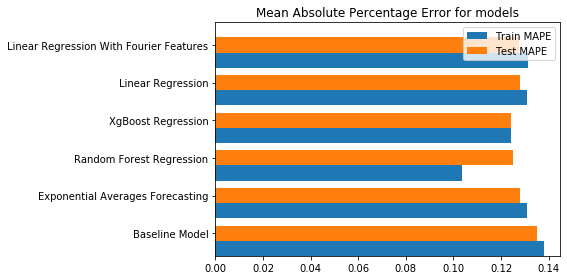

In [116]:
df = pd.DataFrame(dict(graph=['Baseline Model', 'Exponential Averages Forecasting', 'Random Forest Regression','XgBoost Regression','Linear Regression','Linear Regression With Fourier Features'],
                           n=train_mape, m=test_mape)) 

ind = np.arange(len(df))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, df.n, width, label='Train MAPE')
ax.barh(ind + width, df.m, width, label='Test MAPE')
fig.set_figwidth(8)
plt.gcf().subplots_adjust(left = 0.40)
plt.title("Mean Absolute Percentage Error for models")
ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend()
plt.tight_layout()
plt.show()

LSTM

In [117]:
df_train['y']=(pd.Series(train_output).values)
df_test['y']=(pd.Series(test_output).values)


In [118]:
# Normalize
scaler=MinMaxScaler(feature_range=(0, 1))
df_train = scaler.fit_transform(df_train)
df_test=scaler.fit_transform(df_test)

In [119]:
def create_dataset(dataset, look_back=1): #lookback is how many prev time steps to use as i/p var
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [120]:
traindata=df_train[:int(len(df_train)*.8)]
valdata=df_train[int(len(df_train)*.8):]

In [121]:
print('Train data:',len(traindata),'\t Val Data:',len(valdata))

Train data: 293408 	 Val Data: 73352


In [122]:
# reshape into X=t and Y=t+1
look_back = 18
trainx, trainy = create_dataset(traindata, look_back)
valx,valy= create_dataset(valdata,look_back)
testx, testy = create_dataset(df_test, look_back)

# shape -> [samples, features] expcted shape by lstm -> [samples, time steps, features].
trainx=np.reshape(trainx,(trainx.shape[0],1,trainx.shape[1]))
valx=np.reshape(valx,(valx.shape[0],1,valx.shape[1]))
testx=np.reshape(testx,(testx.shape[0],1,testx.shape[1]))

In [123]:
model = tf.keras.Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
tf.keras.backend.set_epsilon(1)
model.compile(loss='mse', optimizer='adam', metrics=['mae','mape'])
historyy=model.fit(trainx, trainy, epochs=50, batch_size=100, verbose=2,validation_data=(valx,valy))

Train on 293389 samples, validate on 73333 samples
Epoch 1/50
293389/293389 - 8s - loss: 9.0519e-04 - mae: 0.0183 - mape: 1.8301 - val_loss: 3.6582e-04 - val_mae: 0.0120 - val_mape: 1.2039
Epoch 2/50
293389/293389 - 7s - loss: 5.4942e-04 - mae: 0.0147 - mape: 1.4704 - val_loss: 3.7238e-04 - val_mae: 0.0125 - val_mape: 1.2484
Epoch 3/50
293389/293389 - 7s - loss: 5.3532e-04 - mae: 0.0145 - mape: 1.4533 - val_loss: 3.5083e-04 - val_mae: 0.0117 - val_mape: 1.1713
Epoch 4/50
293389/293389 - 8s - loss: 5.3210e-04 - mae: 0.0145 - mape: 1.4480 - val_loss: 3.5370e-04 - val_mae: 0.0118 - val_mape: 1.1810
Epoch 5/50
293389/293389 - 8s - loss: 5.3098e-04 - mae: 0.0145 - mape: 1.4468 - val_loss: 3.5889e-04 - val_mae: 0.0124 - val_mape: 1.2403
Epoch 6/50
293389/293389 - 7s - loss: 5.2915e-04 - mae: 0.0144 - mape: 1.4435 - val_loss: 3.4973e-04 - val_mae: 0.0118 - val_mape: 1.1831
Epoch 7/50
293389/293389 - 7s - loss: 5.2806e-04 - mae: 0.0144 - mape: 1.4429 - val_loss: 3.5484e-04 - val_mae: 0.0121 - 

In [124]:
score=model.evaluate(testx, testy)
print(score)

157181/157181 [==============================] - 5s 35us/sample - loss: 5.3784e-04 - mae: 0.0146 - mape: 1.4599
[0.0005378443879901506, 0.0145991435, 1.4599124]


test score : 0.0005378443879901506
test Accuracy mape : 1.4599124
test Accuracy mae : 0.0145991435
train accuracy mape: 1.4171476
train accuracy mae: 0.0141714765


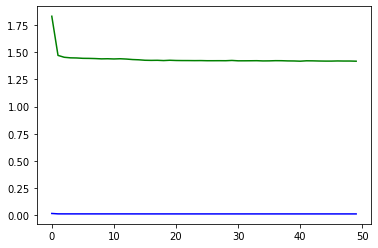

In [125]:
test_score=score[0]
test_accuracy_mae=score[1]
test_accuracy_mape=score[2]
train_accuracy_mape=min(historyy.history['mape'])
train_accuracy_mae=min(historyy.history['mae'])
print('test score :',test_score)
print('test Accuracy mape :',test_accuracy_mape)
print('test Accuracy mae :',test_accuracy_mae)
print('train accuracy mape:',train_accuracy_mape)
print('train accuracy mae:',train_accuracy_mae)
plt.plot(historyy.history['mae'],'b', label='mean_absolute_error')
plt.plot(historyy.history['mape'],'g', label='mean_absolute_percentage_error')
plt.show()

lstms are underfitting